# Lecture 7: Data Wrangling — Aggregation, Pivoting & Merging






In [2]:
import pandas as pd

df = pd.DataFrame({
    "Region":  ["East","West","East","North","West","South","East","North","East"],
    "Product": ["A","A","B","A","C","B","C","B","A"],
    "Month":   ["Jan","Jan","Feb","Feb","Feb","Mar","Mar","Mar","Mar"],
    "Sales":   [2000, 2500, 1800, 2200, 2700, 1600, 2100, 1900,2300],
    "Profit":  [ 400,  500,  350,  420,  530,  300,  450,  380, 240]
})
df.head()

,Region,Product,Month,Sales,Profit
0,East,A,Jan,2000,400
1,West,A,Jan,2500,500
2,East,B,Feb,1800,350
3,North,A,Feb,2200,420
4,West,C,Feb,2700,530


## 1) Grouping & Aggregation
**Why:** Summarize large numbers of rows into meaningful business totals/averages.

### Group by a single column
What is **total Sales** and **average Profit** per `Region`?

In [3]:


print(df.groupby("Region")["Sales"].sum(), '\n')





Region
East     8200
North    4100
South    1600
West     5200
Name: Sales, dtype: int64 



- Groupby achieved grouping through three steps:
    - split - the data is separated into groups depending on your grouping variable
    - apply - once separated, the specified function is applied to each group
    - combine - the results of the function are combined to created the grouped dataset
- Common functions to call are: count, sum, mean, median, std, var, min, max, prod, first, last
    - .describe() can be used to retrieve group statistics
    - .apply() allows you to pass your own functions
    - .as_index=False suppresses the default of using key levels as index

In [4]:
# Group rows by Region, then aggregate Sales and Profit using different functions
by_region = df.groupby("Region").agg({"Sales": "sum", "Profit": "mean"})
print(by_region)

# Interpretation:
# - Rows become unique regions.
# - 'Sales' is summed within each region.
# - 'Profit' is averaged within each region.

        Sales  Profit
Region               
East     8200   360.0
North    4100   400.0
South    1600   300.0
West     5200   515.0


###  Group by two columns (multi-key)
 For each `(Region, Product)` pair, what are total Sales?
The result uses a **MultiIndex** (rows indexed by two keys).

In [5]:
by_region_product = df.groupby(["Region","Product"])["Sales"].sum()
print(by_region_product)

# Flatten to regular columns if desired
print("\nAs flat columns:")
print(by_region_product.reset_index())


Region  Product
East    A          4300
        B          1800
        C          2100
North   A          2200
        B          1900
South   B          1600
West    A          2500
        C          2700
Name: Sales, dtype: int64

As flat columns:
  Region Product  Sales
0   East       A   4300
1   East       B   1800
2   East       C   2100
3  North       A   2200
4  North       B   1900
5  South       B   1600
6   West       A   2500
7   West       C   2700


### Multiple aggregations per column (named results)
Use **named aggregation** for readable output column names.

In [6]:
by_region_multiagg = (
    df.groupby("Region")
      .agg(Sales_sum=("Sales","sum"),
           Sales_mean=("Sales","mean"),
           Profit_sum=("Profit","sum"),
           Profit_mean=("Profit","mean"))
)
print(by_region_multiagg)

        Sales_sum  Sales_mean  Profit_sum  Profit_mean
Region                                                
East         8200      2050.0        1440        360.0
North        4100      2050.0         800        400.0
South        1600      1600.0         300        300.0
West         5200      2600.0        1030        515.0


###  Keep group keys as normal columns (`as_index=False`)
Beginners often prefer group keys as columns instead of index.

In [7]:
by_region_plain = (
    df.groupby("Region", as_index=False)
      .agg(Sales_sum=("Sales","sum"), Profit_mean=("Profit","mean"))
)
print(by_region_plain)

  Region  Sales_sum  Profit_mean
0   East       8200        360.0
1  North       4100        400.0
2  South       1600        300.0
3   West       5200        515.0


### Counting patterns: 
- `size()` counts **rows** per group
- `count()` counts **non-null values** in a column per group

In [10]:
print("Rows per Region (size):")
print(df.groupby("Region").size())

print("\nDistinct counts per Region:")
print(df.groupby("Region").count())



Rows per Region (size):
Region
East     4
North    2
South    1
West     2
dtype: int64

Distinct counts per Region:
        Product  Month  Sales  Profit
Region                               
East          4      4      4       4
North         2      2      2       2
South         1      1      1       1
West          2      2      2       2


## 3) `pivot_table` — Aggregated Matrix (like Excel Pivot)
`pivot_table` lets you choose which **value** to aggregate and how.

### Sum of Sales by Region (rows) × Month (columns)

In [11]:
pt = pd.pivot_table(
    df,
    values="Sales",      # which numeric column to aggregate
    index="Region",      # rows
    columns="Month",     # columns
    aggfunc="sum",       # aggregation
    fill_value=0         # replace missing combos with 0
)
print(pt)

# Interpretation:
# - Each cell = total Sales for that Region–Month combination.


Month    Feb   Jan   Mar
Region                  
East    1800  2000  4400
North   2200     0  1900
South      0     0  1600
West    2700  2500     0


###  Multiple values & aggregations
Show `Sales` (sum) and `Profit` (mean) in one pivot. This creates a **MultiIndex** on the columns.

In [12]:
pt_multi = pd.pivot_table(
    df,
    values=["Sales","Profit"],
    index="Region",
    columns="Month",
    aggfunc={"Sales": "sum", "Profit": "mean"},
    fill_value=0
)
print(pt_multi)



       Profit               Sales            
Month     Feb    Jan    Mar   Feb   Jan   Mar
Region                                       
East    350.0  400.0  345.0  1800  2000  4400
North   420.0    0.0  380.0  2200     0  1900
South     0.0    0.0  300.0     0     0  1600
West    530.0  500.0    0.0  2700  2500     0


###  Add grand totals (`margins=True`)

In [13]:
pt_with_totals = pd.pivot_table(
    df, values="Sales", index="Region", columns="Month",
    aggfunc="sum", fill_value=0, margins=True, margins_name="Total"
)
print(pt_with_totals)

Month    Feb   Jan   Mar  Total
Region                         
East    1800  2000  4400   8200
North   2200     0  1900   4100
South      0     0  1600   1600
West    2700  2500     0   5200
Total   6700  4500  7900  19100


## 2) `crosstab` — Frequency Tables
 Quick counts across two categorical variables.

### Basic frequency table

In [14]:
xt = pd.crosstab(df["Region"], df["Product"])
print(xt)

# Interpretation:
# - Each cell shows the number of transactions for that Region–Product pair.

Product  A  B  C
Region          
East     2  1  1
North    1  1  0
South    0  1  0
West     1  0  1


In [15]:
# ###  Add row/column totals (`margins=True`)
xt_margins = pd.crosstab(df["Region"], df["Product"], margins=True, margins_name="Total")
print(xt_margins, '\n')

Product  A  B  C  Total
Region                 
East     2  1  1      4
North    1  1  0      2
South    0  1  0      1
West     1  0  1      2
Total    4  3  2      9 



###  Proportions instead of counts (`normalize=`)
- `normalize='index'` → row percentages (each row sums to 1)
- `normalize='columns'` → column percentages (each column sums to 1)
- `normalize=True` → overall percentages (full table sums to 1)

In [16]:



row_props = pd.crosstab(df["Region"], df["Product"], normalize="index").round(2)
col_props = pd.crosstab(df["Region"], df["Product"], normalize="columns").round(2)
overall_props = pd.crosstab(df["Region"], df["Product"], normalize=True).round(2)

print("Row-normalized (within each Region):")
print(row_props)
print("\nColumn-normalized (within each Product):")
print(col_props)
print("\nOverall proportions:")
print(overall_props)

Row-normalized (within each Region):
Product    A     B     C
Region                  
East     0.5  0.25  0.25
North    0.5  0.50  0.00
South    0.0  1.00  0.00
West     0.5  0.00  0.50

Column-normalized (within each Product):
Product     A     B    C
Region                  
East     0.50  0.33  0.5
North    0.25  0.33  0.0
South    0.00  0.33  0.0
West     0.25  0.00  0.5

Overall proportions:
Product     A     B     C
Region                   
East     0.22  0.11  0.11
North    0.11  0.11  0.00
South    0.00  0.11  0.00
West     0.11  0.00  0.11


## Reshaping (wide-long)

In [20]:
pt = pd.pivot_table(
    df,
    values="Sales",      # which numeric column to aggregate
    index="Region",      # rows
    columns="Month",     # columns
    aggfunc="sum",       # aggregation
    fill_value=0         # replace missing combos with 0
)
print(pt)

Month    Feb   Jan   Mar
Region                  
East    1800  2000  4400
North   2200     0  1900
South      0     0  1600
West    2700  2500     0


In [18]:
pt_multi = pd.pivot_table(
    df,
    values=["Sales","Profit"],
    index="Region",
    columns="Month",
    aggfunc={"Sales": "sum", "Profit": "mean"},
    fill_value=0
)
print(pt_multi)


       Profit               Sales            
Month     Feb    Jan    Mar   Feb   Jan   Mar
Region                                       
East    350.0  400.0  345.0  1800  2000  4400
North   420.0    0.0  380.0  2200     0  1900
South     0.0    0.0  300.0     0     0  1600
West    530.0  500.0    0.0  2700  2500     0


In [21]:
#unstack allows us to move one index level to a column index (defaults to lower level; can specify level)
print(pt.unstack(),'\n')
print(pt_multi.unstack()) #HIdf.unstack(level=0)

Month  Region
Feb    East      1800
       North     2200
       South        0
       West      2700
Jan    East      2000
       North        0
       South        0
       West      2500
Mar    East      4400
       North     1900
       South     1600
       West         0
dtype: int64 

        Month  Region
Profit  Feb    East       350.0
               North      420.0
               South        0.0
               West       530.0
        Jan    East       400.0
               North        0.0
               South        0.0
               West       500.0
        Mar    East       345.0
               North      380.0
               South      300.0
               West         0.0
Sales   Feb    East      1800.0
               North     2200.0
               South        0.0
               West      2700.0
        Jan    East      2000.0
               North        0.0
               South        0.0
               West      2500.0
        Mar    East      4400.0
             

In [24]:
#stack will change from column to row index
print(pt.stack(),'\n')


Region  Month
East    Feb      1800
        Jan      2000
        Mar      4400
North   Feb      2200
        Jan         0
        Mar      1900
South   Feb         0
        Jan         0
        Mar      1600
West    Feb      2700
        Jan      2500
        Mar         0
dtype: int64 



In [27]:
#melt is the general tool for converting many columns that are the same measurement into rows.
wide = pd.DataFrame({
    'Name': ['Alice','Bob'],
    'Q1': [100, 200],
    'Q2': [150, 400]
})
print("Wide:")
print(wide)

long = wide.melt(id_vars='Name', var_name='Quarter', value_name='Sales')
print("\nLong (after melt):")
print(long)

Wide:
    Name   Q1   Q2
0  Alice  100  150
1    Bob  200  400

Long (after melt):
    Name Quarter  Sales
0  Alice      Q1    100
1    Bob      Q1    200
2  Alice      Q2    150
3    Bob      Q2    400


##  Merge / Join — Combine Related Tables
**Why:** Enrich a transaction table with attributes from another table (like customer tiers or product info).

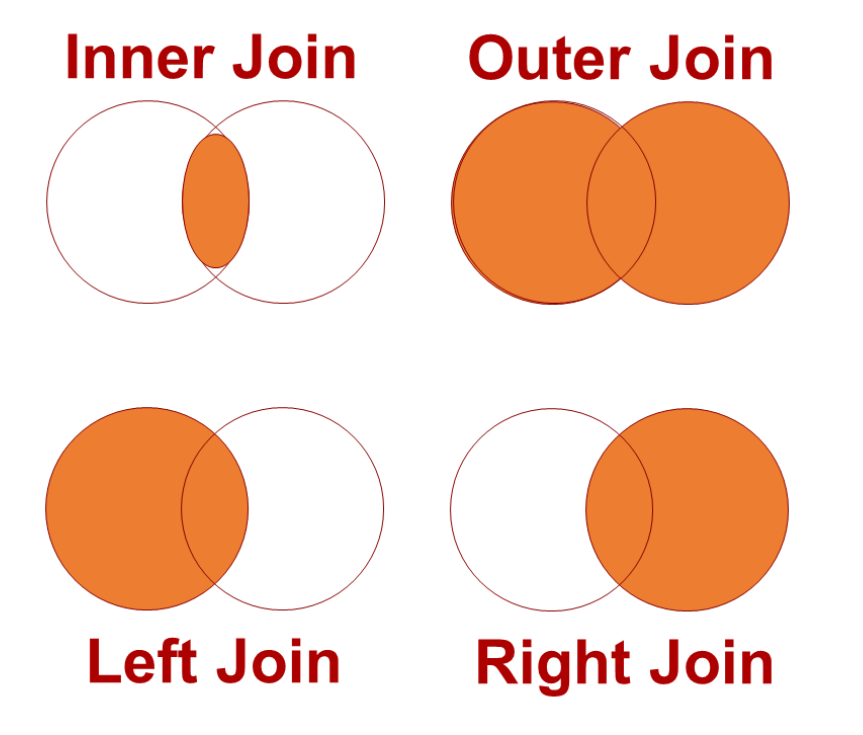

### Merges and join
- links rows based on keys present in the data
- common in data wrangling and cleaning
- many to many joins will result in the Cartesian product of rows
    - if there a 3 rows with the key value of 'b' in the first DataFrame and 2 rows with the key value of 'b' in the second DataFrame, the resulting DataFrame will have 6 'b' rows
    - This behavior is often undesirable, deduplicating your DataFrame based on key values prior to merges can help avoid this
- types of joins: 

    - Inner - only keeps rows where key is present in both DataFrames
    - Outer - keeps rows where key is present in either DataFrame
    - Left - only keeps rows where key is present in left (or first) DataFrame
    - Right - only keeps rows where key is present in right (or second) DataFrame

| Feature                  | `merge()`                                          | `join()`                                            |
| ------------------------ | -------------------------------------------------- | --------------------------------------------------- |
| **Purpose**              | Combine two DataFrames using **column(s)** as keys | Combine two DataFrames using **index** (by default) |
| **Syntax**               | `pd.merge(df1, df2, on='key')`                     | `df1.join(df2, on='key')`                           |
| **Join Types Supported** | `'left'`, `'right'`, `'inner'`, `'outer'`          | `'left'`, `'right'`, `'inner'`, `'outer'`           |
| **Where Defined**        | Works like SQL joins                               | Works like SQL “join on index”                      |
| **Flexibility**          | Very flexible — can join on multiple columns       | Simpler, convenient for joining on indexes          |
| **Default Join Key**     | Must specify with `on=` (no default)               | Uses DataFrame **index** unless specified           |


In [30]:
# Example customer table keyed by Region (toy example for demonstration)
customers = pd.DataFrame({
    "Region":       ["East","West","North","South","West","East"],
    "Loyalty_Tier": ["Gold","Silver","Bronze","Gold","Platinum","Silver"]
})
print(df,'\n')
print(customers,'\n')
merged = pd.merge(df, customers, on="Region", how="left")
print("Rows before:", len(df), " | Rows after merge:", len(merged))
merged.head(15)


# - how='left' keeps ALL rows from df and matches attributes from customers when possible.
# - Unmatched keys will yield NaN in new columns — that's honest and expected.


  Region Product Month  Sales  Profit
0   East       A   Jan   2000     400
1   West       A   Jan   2500     500
2   East       B   Feb   1800     350
3  North       A   Feb   2200     420
4   West       C   Feb   2700     530
5  South       B   Mar   1600     300
6   East       C   Mar   2100     450
7  North       B   Mar   1900     380
8   East       A   Mar   2300     240 

  Region Loyalty_Tier
0   East         Gold
1   West       Silver
2  North       Bronze
3  South         Gold
4   West     Platinum
5   East       Silver 

Rows before: 9  | Rows after merge: 15


,Region,Product,Month,Sales,Profit,Loyalty_Tier
0,East,A,Jan,2000,400,Gold
1,East,A,Jan,2000,400,Silver
2,West,A,Jan,2500,500,Silver
3,West,A,Jan,2500,500,Platinum
4,East,B,Feb,1800,350,Gold
5,East,B,Feb,1800,350,Silver
6,North,A,Feb,2200,420,Bronze
7,West,C,Feb,2700,530,Silver
8,West,C,Feb,2700,530,Platinum
9,South,B,Mar,1600,300,Gold


In [31]:
# Check if a join key is unique on a table before merging
print("Duplicate Region rows in customers? ->", customers.duplicated(subset=["Region"]).sum(), "duplicates")

Duplicate Region rows in customers? -> 2 duplicates


###  Multi-key merge (e.g., Product + Month)
Real-world joins often depend on **two keys** (granularity awareness).

In [32]:
rates = pd.DataFrame({
    "Product": ["A","A","B","B","C","C"],
    "Month":   ["Jan","Feb","Jan","Mar","Feb","Mar"],
    "TaxRate": [0.07, 0.07, 0.05, 0.05, 0.08, 0.08]
})

df2 = pd.merge(df, rates, on=["Product","Month"], how="left")
df2[["Region","Product","Month","Sales","TaxRate"]]


,Region,Product,Month,Sales,TaxRate
0,East,A,Jan,2000,0.07
1,West,A,Jan,2500,0.07
2,East,B,Feb,1800,NaN
3,North,A,Feb,2200,0.07
4,West,C,Feb,2700,0.08
5,South,B,Mar,1600,0.05
6,East,C,Mar,2100,0.08
7,North,B,Mar,1900,0.05
8,East,A,Mar,2300,NaN


In [33]:
emaildf=pd.read_excel(r"Customeremail (1).xlsx")

In [34]:
df=pd.read_excel(r"CustomerBehavior2.xlsx")

In [35]:
df2=df.copy()

In [36]:
emaildf.head(10)

,Name,Year,Quarter,Transaction,Spent,Refunded,CustID,Email
0,Jane,2022,2,1,37,0,12,Jane.Smith@yahoo.com
1,Adam,2022,3,3,39,0,5,Adam.John@gmail.com
2,George,2022,3,1,43,0,7,G_Man_88@gmail.com
3,Sally,2022,3,2,0,31,15,Sally_Matthews@funcollege.edu
4,Trisha,2022,3,1,41,0,20,teyoun22@thisschool.edu


In [37]:
df2.head(10)

,Name,Year,Quarter,Transaction,Spent,Refunded
0,Jane,2021.0,4.0,1.0,31.0,NaN
1,Jane,2021.0,4.0,1.0,31.0,NaN
2,Jane,2022.0,1.0,1.0,53.0,NaN
3,Jane,NaN,NaN,2.0,41.0,NaN
4,Jane,NaN,2.0,1.0,37.0,NaN
5,Adam,2022.0,3.0,1.0,32.0,NaN
6,Adam,NaN,NaN,2.0,34.0,NaN
7,Adam,NaN,NaN,3.0,39.0,NaN
8,George,2021.0,4.0,1.0,56.0,NaN
9,George,2021.0,4.0,1.0,56.0,NaN


In [38]:
# .merge() - will automatically try to merge on shared columns, can specify key using 'on'
#print(pd.merge(df2,emaildf, on='Name'))
    #can specify multiple keys
#print(pd.merge(df2,emaildf, on=['Name','Year']))
    #can specify keys for each data set using left_on and right_on allowing for keys to be named differently
#pd.merge(df2,emaildf, left_on='Name',right_on='Name')
    #keys can be index using left_index=True or right_index=True or both.
#pd.merge(df2,emaildf, left_index=True,right_index=True)
    #can specify type of merge using how. options are 'inner', 'left', 'right', 'outer' (default is 'inner').
#print(pd.merge(df2,emaildf, on='Name', how='outer'))
    #when there are overlapping columns names, can specify a string to be appended to the column name using suffixes.
    #Default is _x for left DataFrame, _y for right DataFrame
#print(pd.merge(df2,emaildf, on='Name',suffixes=('_left','_right')))
dfn12=pd.merge(df2,emaildf, on='Name')
dfn12.head(10)

,Name,Year_x,Quarter_x,Transaction_x,Spent_x,Refunded_x,Year_y,Quarter_y,Transaction_y,Spent_y,Refunded_y,CustID,Email
0,Jane,2021.0,4.0,1.0,31.0,NaN,2022,2,1,37,0,12,Jane.Smith@yahoo.com
1,Jane,2021.0,4.0,1.0,31.0,NaN,2022,2,1,37,0,12,Jane.Smith@yahoo.com
2,Jane,2022.0,1.0,1.0,53.0,NaN,2022,2,1,37,0,12,Jane.Smith@yahoo.com
3,Jane,NaN,NaN,2.0,41.0,NaN,2022,2,1,37,0,12,Jane.Smith@yahoo.com
4,Jane,NaN,2.0,1.0,37.0,NaN,2022,2,1,37,0,12,Jane.Smith@yahoo.com
5,Adam,2022.0,3.0,1.0,32.0,NaN,2022,3,3,39,0,5,Adam.John@gmail.com
6,Adam,NaN,NaN,2.0,34.0,NaN,2022,3,3,39,0,5,Adam.John@gmail.com
7,Adam,NaN,NaN,3.0,39.0,NaN,2022,3,3,39,0,5,Adam.John@gmail.com
8,George,2021.0,4.0,1.0,56.0,NaN,2022,3,1,43,0,7,G_Man_88@gmail.com
9,George,2021.0,4.0,1.0,56.0,NaN,2022,3,1,43,0,7,G_Man_88@gmail.com


In [40]:
#.join() merges DataFrames based on index
#setting index to key
df3=df2.set_index('Name')
emaildf3=emaildf.set_index('Name')
#.join()
print(df3.join(emaildf3, rsuffix='_right')) # note must specify suffix for overlapping columns
    #can specify multiple data sets to join
#print(df3.join([emaildf3,otherdf])) # this is not executable
    #can specify type of merge using how. options are 'inner', 'left', 'right', 'outer' (default is 'left').
print(df3.join(emaildf3, rsuffix='_right', how='outer'))

          Year  Quarter  Transaction  Spent  Refunded  Year_right  \
Name                                                                
Jane    2021.0      4.0          1.0   31.0       NaN      2022.0   
Jane    2021.0      4.0          1.0   31.0       NaN      2022.0   
Jane    2022.0      1.0          1.0   53.0       NaN      2022.0   
Jane       NaN      NaN          2.0   41.0       NaN      2022.0   
Jane       NaN      2.0          1.0   37.0       NaN      2022.0   
Adam    2022.0      3.0          1.0   32.0       NaN      2022.0   
Adam       NaN      NaN          2.0   34.0       NaN      2022.0   
Adam       NaN      NaN          3.0   39.0       NaN      2022.0   
George  2021.0      4.0          1.0   56.0       NaN      2022.0   
George  2021.0      4.0          1.0   56.0       NaN      2022.0   
George     NaN      NaN          2.0    NaN      36.0      2022.0   
George  2022.0      1.0          1.0   35.0       NaN      2022.0   
George     NaN      NaN          2